# Fine Tuning Process

## Setup

##### Imports

In [1]:
import warnings; warnings.filterwarnings('ignore')
import sys; sys.path.append('../libraries')
import os
import pandas as pd
import numpy as np
import logging
import tweetnlp
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from kneed import KneeLocator
from utils import probabilites2entropy

##### Configuration

In [2]:
# Set logging config 
logging.basicConfig(format='%(asctime)s %(levelname)-8s %(message)s', level=logging.INFO, datefmt='%Y-%m-%d %H:%M:%S')

# Set language model and task type
base_model = "cardiffnlp/twitter-roberta-base-dec2021-emotion"
task = 'emotion'

# Labels mapping
label_to_id = {'anger': 0, 'joy': 1, 'optimism': 2, 'sadness': 3}

# Set seed for reproducibility
seed = 28

##### Filepaths & Constants

In [3]:
# Paths
root = '../../data/'
finetuning = root + f'2- NLP/1- Fine Tuning'
annotations = finetuning + '/annotations'

# Dict of networks
networks = {
    "us_congressmen": {},
    "journalists": {},
    "universities": {},
    "all": {}
    }

### Load annotated data

Annotated data is split into raw_data, with the text that was annotated, and batch summary with the golden labels assigned to each sample.

In [4]:
samples_list = []
labels_list = []

# Read text and labels from annotation's batch summaries
for f in os.listdir(annotations):

    if f.endswith(" - Samples.csv"):
        t = pd.read_csv(f"{annotations}/{f}", encoding="utf-8")
        samples_list.append(t)
    elif f.endswith(" - Summary.xlsx"):
        l = pd.read_excel(f"{annotations}/{f}", sheet_name="Annotations")
        labels_list.append(l)

# Concatenate together
samples_df = pd.concat(samples_list).reset_index(drop=True)
labels_df = pd.concat(labels_list).reset_index(drop=True)

for net in networks.keys():

    if net != "all":

        # Get samples and labels for the current network
        mask = samples_df[samples_df.network == net].index
        texts = samples_df.iloc[mask].text
        labels = labels_df.iloc[mask].GOLDEN
    
    else:
        texts = samples_df.text
        labels = labels_df.GOLDEN

    # Put samples and labels together
    finetune_data = pd.DataFrame(data=[texts.reset_index(drop=True), labels.reset_index(drop=True)], index=None).T
    finetune_data.columns = ["text", "label"]

    # Remove the undefined
    finetune_data = finetune_data[finetune_data.label != "undefined"]
    # Transform the labels into numeric to match model's categories
    finetune_data["label"] = finetune_data.label.map(label_to_id)
    
    # Split in Train/Test and Save to file
    train, test = train_test_split(finetune_data, test_size = 0.2, random_state = seed)
    train.to_csv(f"{finetuning}/{net}/train.csv", encoding="utf-8", index=False)
    test.to_csv(f"{finetuning}/{net}/test.csv", encoding="utf-8", index=False)

    # Map data files to splits
    data_files = {'train': 'train.csv', 'test': 'test.csv'}
    ds = load_dataset(f"{finetuning}/{net}", data_files = data_files)

    # Incorporate to networks
    networks[net]["samples"] = finetune_data
    networks[net]["finetuning_set"] = ds

    print(f"Network {net} has {finetune_data.shape[0]} samples / Train: {train.shape[0]} / Test: {test.shape[0]}")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/ginof/.cache/huggingface/datasets/csv/us_congressmen-bbf00054d046e069/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Network us_congressmen has 1702 samples / Train: 1361 / Test: 341


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/ginof/.cache/huggingface/datasets/csv/journalists-9a54257e299b3a13/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Network journalists has 1140 samples / Train: 912 / Test: 228


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/ginof/.cache/huggingface/datasets/csv/universities-54b4d5bc363c9b28/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Network universities has 1231 samples / Train: 984 / Test: 247


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/ginof/.cache/huggingface/datasets/csv/all-3f657748c39efd1e/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Network all has 4220 samples / Train: 3376 / Test: 844


### Predict with baseline model and calculate accuracy

In [5]:
baseline = False

if baseline:
    # Load baseline model
    model = tweetnlp.Classifier(base_model, max_length=128)

    for net in networks.keys():

        # Predict annotated samples
        preds = model.predict(networks[net]["samples"].text, return_probability=True)
        # Convert into array of id values
        preds = pd.DataFrame(preds)

        # Store results
        networks[net]["predictions"] = probabilites2entropy(preds)
        networks[net]["predictions"]["label_map"] = networks[net]["predictions"]["label"].map(label_to_id)
        networks[net]["predictions"]["golden"] = networks[net]["samples"].label

        # Calculate accuracy:
        y_hat = preds.label.map(label_to_id)
        acc = accuracy_score(networks[net]["samples"].label, y_hat)
        networks[net]["metrics"] = {"baseline_accuracy": acc}
        print(f"Network {net} -> Accuracy of Baseline Model: {acc:.2%}")

## Fine-tuning Baseline Models

### Train and evaluate on test set

In [6]:
finetune = False

if finetune:

    for net in networks.keys():

        print(f"Training {net} network")
        
        # Load trainer
        trainer_class = tweetnlp.load_trainer(task)

        # Define trainer
        trainer = trainer_class(
            language_model = base_model,
            dataset = networks[net]["finetuning_set"],
            label_to_id = label_to_id,
            split_train = 'train',
            split_test = 'test',
            output_dir = f'finetuned_model/{net}')

        # Train
        trainer.train(down_sample_size_train = 1000, ray_result_dir = "finetuned_model/{net}")

        # Model evaluation
        metrics = trainer.evaluate()
        print(f"Accuracy on Test set after fine-tuning: {metrics['eval_accuracy']:.2%}")

        # Save fine-tuned model
        trainer.save_model(f"./finetuned_model/{net}/")

## Fine Tuning the "undefined" label

Once finetuned the model, we need to find an appropiate cutoff for the entropy levels, to reject low confidence predictions and assign them as "undefined" emotion label. We do this process only on the combined "all" fine tuned model, since this probed to have better results. 

### Now let's do the selective decision making

##### We load the test set used for finetuning

In [7]:
# Load the test set from fine tuning
x = networks["all"]["finetuning_set"]["test"]["text"]
y = networks["all"]["finetuning_set"]["test"]["label"]

##### We load the samples with "undefined" label that were not included in the finetuning

In [8]:
und_labels = labels_df[labels_df.GOLDEN == "undefined"]
und_samples = samples_df.loc[und_labels.index]
pct_undefined = und_labels.shape[0] / samples_df.shape[0]

##### Extended test set: We add the samples with "undefined" label in the same proportion as found in the annotations

In [9]:
# Number of defined samples
def_samples = len(x)
# Total required samples to satisfy the proportion encountered in annotations
tot_samples = int(len(x) / (1-pct_undefined))
# Amount of 'undefined' samples to incorporate
und_add = tot_samples - def_samples

print(f"Number of samples with defined label: {def_samples}")
print(f"Total number of samples required: {tot_samples}")
print(f"Number of 'undefined' samples to incorporate: {und_add}")

Number of samples with defined label: 844
Total number of samples required: 1390
Number of 'undefined' samples to incorporate: 546


In [10]:
# Randomly choose samples with "undefined" label in the same proportion as found in annotations
np.random.seed(seed)
ixs = np.random.randint(0, high=und_samples.text.shape[0], size=und_add, dtype=int)

# Append the "undefined" samples to the test set
x = x + list(und_samples.text.reset_index(drop=True)[ixs])
y = y + list(und_labels.GOLDEN.reset_index(drop=True)[ixs])

# Change value "undefined" to numeric
y = [4 if i == "undefined" else i for i in y]

##### We load the fine tuned model and we make predictions on our "extended" test set

In [11]:
# Load the model
model = tweetnlp.load_model('emotion', model_name="./models/all/")

# We predict on the test set
preds = model.predict(x, return_probability=True)

##### Calculate the entropy for these predictions, and sort them in descending order

In [12]:
# Calculate entropy for predictions
preds_ = pd.DataFrame(preds)
preds_ = probabilites2entropy(preds_)

# Append the golden label
preds_["golden"] = y

# We map the prediction into numeric
preds_["label"] = preds_.label.map(label_to_id)

# We sort by the normalized entropy in ascending way
all_preds_sorted = preds_.sort_values("nEntropy").reset_index(drop=True)
all_preds_sorted.head()

,label,joy,optimism,anger,sadness,nEntropy,golden
0,2,0.000853,0.998933,0.000076,0.000139,0.006525,2
1,1,0.998923,0.000496,0.000173,0.000409,0.006878,1
2,2,0.000906,0.998865,0.000105,0.000124,0.006898,2
3,1,0.998903,0.000476,0.000155,0.000466,0.006979,1
4,1,0.998903,0.000517,0.000195,0.000385,0.006999,1


In [13]:
preds_.loc[preds_.nEntropy > 0.07596, "label"] = 4
preds_

,label,joy,optimism,anger,sadness,nEntropy,golden
0,4,0.006083,0.018373,0.043063,0.932481,0.220079,1
1,1,0.998716,0.000714,0.000139,0.000431,0.007955,1
2,0,0.000295,0.000157,0.993462,0.006086,0.029820,0
3,1,0.998791,0.000357,0.000197,0.000655,0.007589,1
4,4,0.103353,0.896219,0.000178,0.000250,0.242648,1
...,...,...,...,...,...,...,...
1385,4,0.804349,0.194736,0.000334,0.000581,0.361206,4
1386,1,0.998139,0.001333,0.000145,0.000384,0.010807,4
1387,2,0.001821,0.997784,0.000142,0.000252,0.012300,4
1388,4,0.005144,0.065413,0.100231,0.829212,0.426567,4


In [31]:
pd.DataFrame(confusion_matrix(preds_.golden, preds_.label, normalize=None))

,0,1,2,3,4
0,103,5,2,17,80
1,5,274,8,8,60
2,3,14,38,8,52
3,13,6,2,83,63
4,12,120,17,108,289


<AxesSubplot: >

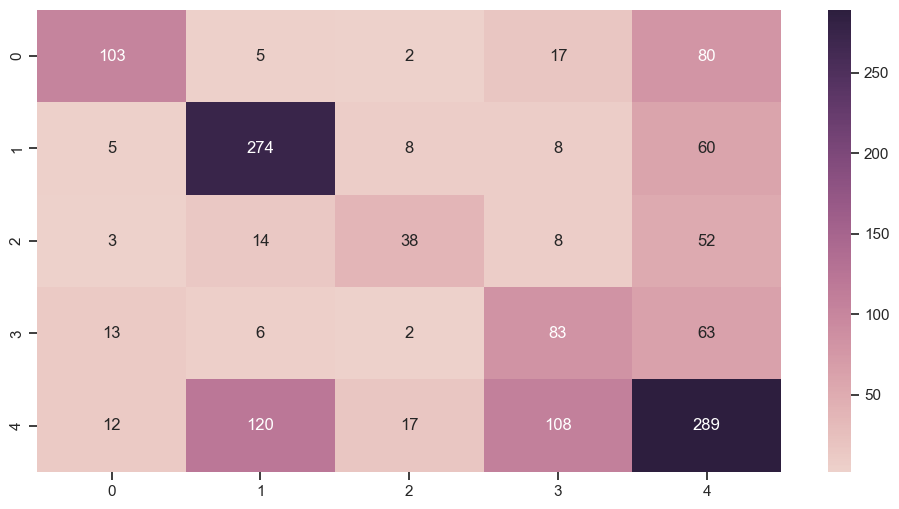

In [26]:
sns.heatmap(confusion_matrix(preds_.golden, preds_.label, normalize=None), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt="g")

In [ ]:
print(f1_score(preds_.golden, preds_.label, average = None))
print(recall_score(preds_.golden, preds_.label, average = None))
print(precision_score(preds_.golden, preds_.label, average = None))

Let's see how the accuracies look when we increase the number of uncertainty of the model

In [15]:
accuracies = []
entropies = []

for i in range(all_preds_sorted.shape[0]):

    acc = accuracy_score(all_preds_sorted.loc[:i,"golden"], all_preds_sorted.loc[:i,"label"])
    accuracies.append(acc)
    entropies.append(round(all_preds_sorted.loc[i,"nEntropy"], 5))

In [16]:
bins = np.logspace(np.log10(min(entropies)), np.log10(max(entropies)), num=10)

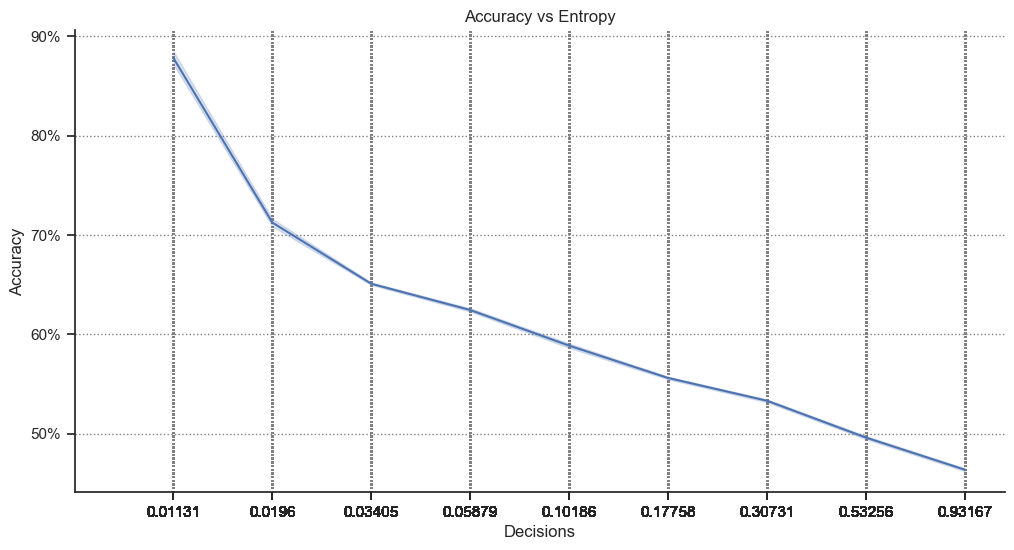

In [17]:
labels = range(1, len(bins))
binned_data = pd.cut(entropies, bins=bins, labels=labels, include_lowest=True)
sns.set(rc={'figure.figsize':(12,6)})
sns.set_style("ticks")
#sns.lineplot(x=entropies, y=accuracies)
sns.lineplot(y= accuracies, x=binned_data)
ylabel = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in ylabel])
plt.ylabel("Accuracy")
plt.xlabel("Decisions")
plt.xticks(binned_data, labels=[str(e) for e in entropies])
plt.title("Accuracy vs Entropy")
plt.grid("y", linestyle="dotted", color="grey")
plt.xlim(0)
sns.despine()
plt.savefig('test.png', dpi=500)
plt.show()

Let's look at the curve

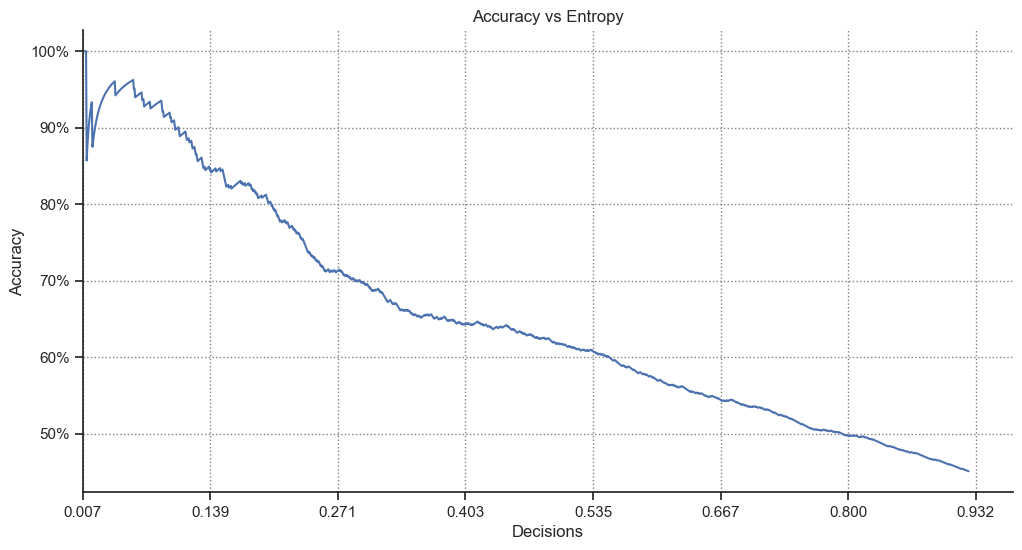

In [18]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set_style("ticks")
#sns.lineplot(x=entropies, y=accuracies)
sns.lineplot(accuracies)
ylabel = plt.gca().get_yticks()
xlabel = plt.gca().get_xticks()
plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in ylabel])
plt.gca().set_xticklabels(["{:.3f}".format(x) for x in np.linspace(entropies[0], entropies[-1], 8)])
plt.ylabel("Accuracy")
plt.xlabel("Decisions")
plt.title("Accuracy vs Entropy")
plt.grid("y", linestyle="dotted", color="grey")
plt.xlim(0)
sns.despine()
plt.show()

##### We apply Savitzky–Golay filter to reduce the noise

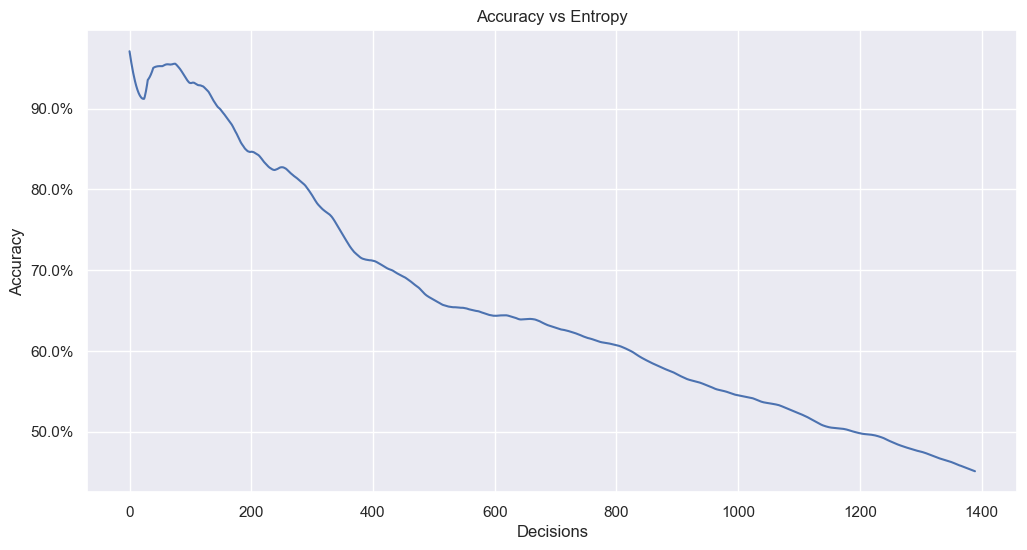

In [19]:
# Apply filter
yhat = savgol_filter(accuracies, 50, 2) # window size 50, polynomial order 3

# Plot
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,6)})
sns.lineplot(yhat)
ylabel = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.1%}'.format(x) for x in ylabel])
plt.ylabel("Accuracy")
plt.xlabel("Decisions")
plt.title("Accuracy vs Entropy")
plt.show()

##### We apply Kneed algorithm

The knee is at 1389 decisions.
That's around 0.93167 of entropy.
This labels 100.00% of the samples.
With an approx. accuracy of 45.11%.


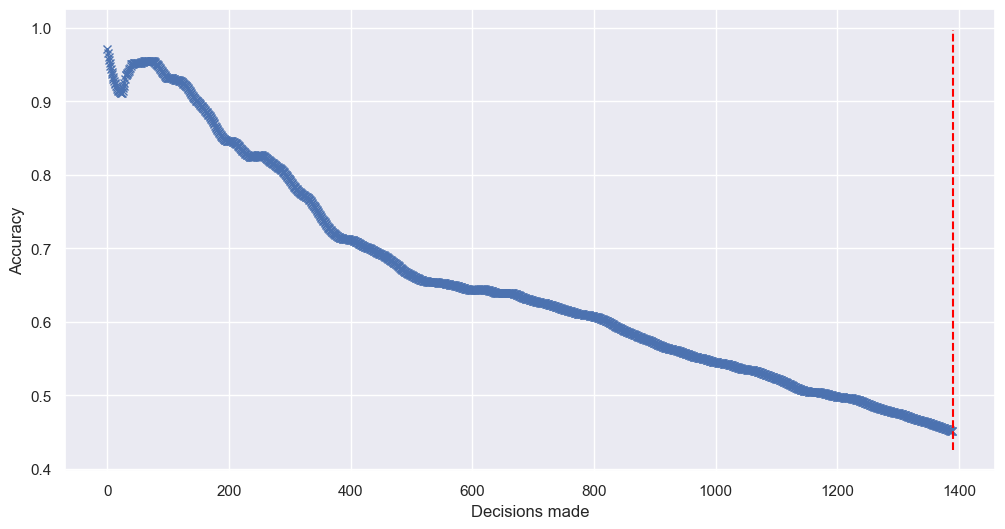

In [20]:
kn = KneeLocator(range(1, len(yhat)+1), yhat, curve='concave', direction='decreasing')
print(f"The knee is at {kn.knee -1} decisions.")
print(f"That's around {entropies[kn.knee -1]} of entropy.")
print(f"This labels {kn.knee / len(entropies):.2%} of the samples.")
print(f"With an approx. accuracy of {accuracies[kn.knee -1]:.2%}.")
plt.xlabel('Decisions made')
plt.ylabel('Accuracy')
plt.plot(yhat, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color="red")

plt.show()

NOTE: Since the curve does not appear to be convex, the algorithm simply finds the knee point to be close to the end of the curve.

Conclusion: We would have expect that the model would recognize the "undefined" samples from the extended test set, assigning them more distributed probabilities across labels, and therefore increasing the entropy. Although the model does decrease its accuracy as entropy increases, there is no clear cut from where the increase in entropy accelerates the decrease of accuracy, giving as a result a quite linear trend. Therefore, we should only choose a cutoff given accuracy or given the proportios of the labels to keep.

### Alternative approach: Find the Entropy that best assimilates the "undefined" distribution of the data

##### Calculate the entropy point that would return the same proportion of defined vs. undefined labels as seen in the annotation stage

In [21]:
entr = np.percentile(entropies, (1-pct_undefined)*100)
print(f"The entropy value cut-off that at returns {pct_undefined:.2%} of the data as 'undefined' is {entr:.5f}.")

The entropy value cut-off that at returns 39.29% of the data as 'undefined' is 0.07596.


##### Let's look at the curve

The knee is at 844 decisions.
That's around 0.07596 of entropy.
This labels 60.71% of the samples.
With an approx. accuracy of 58.93%.


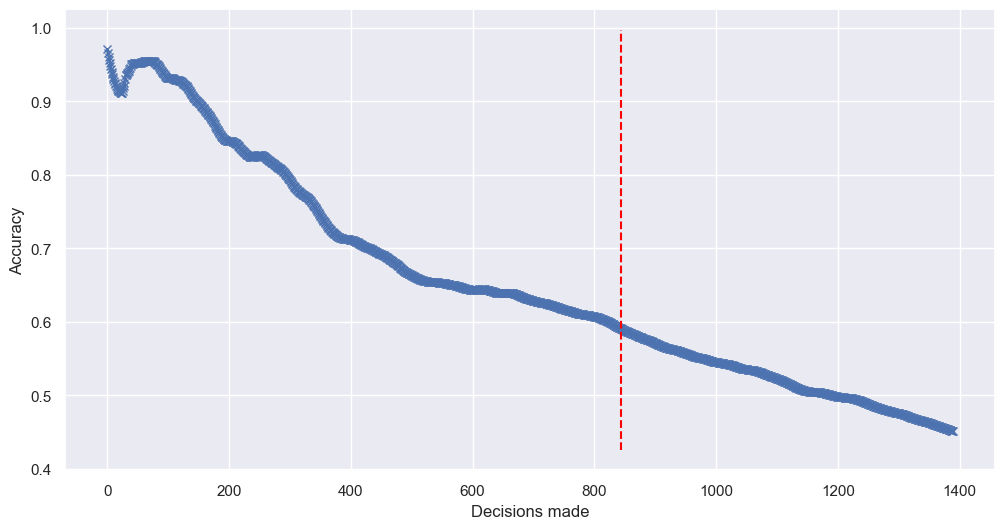

In [22]:
cutoff = round(len(entropies) * (1-pct_undefined))
print(f"The knee is at {cutoff} decisions.")
print(f"That's around {entr:.5f} of entropy.")
print(f"This labels {1-pct_undefined:.2%} of the samples.")
print(f"With an approx. accuracy of {accuracies[cutoff]:.2%}.")
plt.xlabel('Decisions made')
plt.ylabel('Accuracy')
plt.plot(yhat, 'bx-')
plt.vlines(cutoff, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color="red")
plt.show()

##### Finally, let's look at the relationship between sample proportions and entropy levels

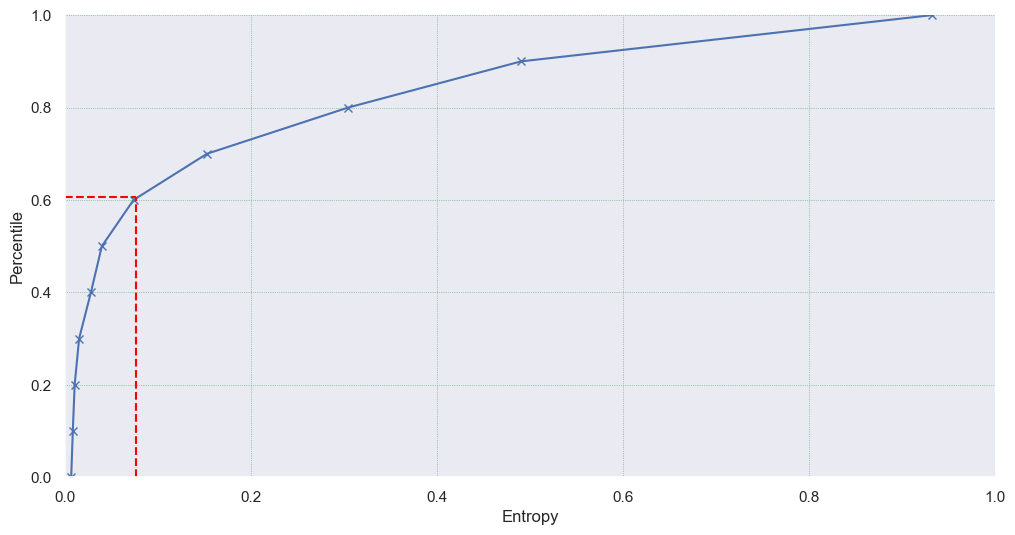

In [23]:
entr = 0.07596
y = np.linspace(0,1,11)
x = np.percentile(entropies, [i * 100 for i in y])

plt.xlabel('Entropy')
plt.ylabel('Percentile')
sns.set_style("ticks")
plt.plot(x, y, 'bx-')
plt.vlines(entr, 0, 1-pct_undefined, linestyles='dashed', color="red")
plt.hlines(1-pct_undefined, 0, entr, linestyles='dashed', color="red")
plt.xlim(0,1)
plt.ylim(0,1)
sns.despine()
plt.grid("y", linestyle="dotted", color="g", linewidth=0.5)
plt.show()